In [1]:
try:
    import firedrake
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/firedrake-install-release-real.sh" -O "/tmp/firedrake-install.sh" && bash "/tmp/firedrake-install.sh"
    import firedrake

In [2]:
try:
  from gusto import *
except ImportError:
  !pip install git+https://github.com/firedrakeproject/gusto
  from gusto import *

INFO     Running /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py -f /root/.local/share/jupyter/runtime/kernel-2e93e961-6124-4784-afff-913c21e9b2ad.json
INFO:gusto:Running /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py -f /root/.local/share/jupyter/runtime/kernel-2e93e961-6124-4784-afff-913c21e9b2ad.json


In [3]:
# Import specific functions from Firedrake
from firedrake import (SpatialCoordinate, TestFunction, TrialFunction, norm,
                       Function, dx, lhs, rhs, inner, LinearVariationalProblem,
                       LinearVariationalSolver, Constant, acos, exp, trisurf,
                       tricontourf, functionspaceimpl, jump, dot, FacetNormal)

In [4]:
try:
  from tomplot import *
except ImportError:
  !pip install git+https://github.com/tommbendall/tomplot.git
  from tomplot import *

In [5]:
try:
  import cartopy.crs as ccrs
except ImportError:
  !pip install cartopy
  import cartopy.crs as ccrs
import numpy as np

In [6]:
# Code in this cell makes plots appear an appropriate size and resolution in the browser window
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
from matplotlib import cm

This next cell contains some functions to interface between Firedrake and Matplotlib and to print out the min and max values of fields (useful when debugging!).

In [7]:
def plot_field(field):
    # function to plot the field and show the plot - could be amended
    # to save a figure instead and other plotting commands can be added
    tsurf = trisurf(field)
    plt.colorbar(tsurf)
    plt.title(field.name())
    plt.show()


def plot_field_latlon(field):
    # function to plot the field and show the plot - could be amended
    # to save a figure instead and other plotting commands can be added

    # We need to regrid onto lon-lat grid -- specify that here
    lon_1d = np.linspace(-180.0, 180.0, 120)
    lat_1d = np.linspace(-90, 90, 120)
    lon_2d, lat_2d = np.meshgrid(lon_1d, lat_1d, indexing='ij')

    projection=ccrs.Robinson()
    contour_method = 'contour'

    # set up figure
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(1, 1, 1, projection=projection)

    # get function space and field data
    if field.name() == 'u':
      mesh = field.function_space().mesh()
      V = FunctionSpace(mesh, "DG", 1)
      xyz = SpatialCoordinate(mesh)
      rotated_pole = (0.0, pi/2)
      e_lon, e_lat, _ = rotated_lonlatr_vectors(xyz, rotated_pole)
      u_zonal = Function(V).interpolate(dot(field, e_lon)).dat.data_ro
      u_merid = Function(V).interpolate(dot(field, e_lat)).dat.data_ro
      field_data = np.sqrt(u_zonal**2 + u_merid**2)
    else:
      V = field.function_space()
      field_data = field.dat.data_ro

    # get lat lon coordinates of DOFs
    x, y, z = SpatialCoordinate(V.mesh())
    lon, lat, _ = lonlatr_from_xyz(x, y, z)
    coords_X = Function(V).interpolate(180.0 / np.pi * lon).dat.data_ro
    coords_Y = Function(V).interpolate(180.0 / np.pi * lat).dat.data_ro

    # map field data to regular lat-lon grid
    field_data = regrid_horizontal_slice(
        lon_2d, lat_2d, coords_X, coords_Y, field_data, periodic_fix='sphere'
    )

    # generate 10 contours between min and max values of field
    contours = np.linspace(field_data.min(), field_data.max(), 10)

    # plot contours
    cmap, lines = tomplot_cmap(contours)
    cf, _ = plot_contoured_field(
        ax, lon_2d, lat_2d, field_data, contour_method, contours,
        cmap=cmap, line_contours=lines, projection=projection
    )

    # add colourbar and title
    add_colorbar_ax(
        ax, cf, field.name(), location='bottom', cbar_labelpad=-10,
    )
    tomplot_field_title(ax, None, minmax=True, field_data=field_data)

    # add quivers if field is velocity
    if field.name() == 'u':
        # Need to re-grid to lat-lon grid to get sensible looking quivers
        regrid_zonal_data = regrid_horizontal_slice(
            lon_2d, lat_2d, coords_X, coords_Y, u_zonal,
            periodic_fix='sphere'
        )
        regrid_meridional_data = regrid_horizontal_slice(
            lon_2d, lat_2d, coords_X, coords_Y, u_merid,
            periodic_fix='sphere'
        )
        plot_field_quivers(
            ax, lon_2d, lat_2d, regrid_zonal_data, regrid_meridional_data,
            spatial_filter_step=6, magnitude_filter=1.0,
            projection=ccrs.PlateCarree()
        )

    # show plot
    plt.show()


def print_minmax(field):
    # function to print the min and max of field in a nice way
    print(f"min and max of {field.name()}: {field.dat.data.min()}, {field.dat.data.max()}")


The next cell contains planetary parameters relevant to Proxima B.

In [8]:
R = 7160000.                 # radius of planet (m)
Omega = 6.501e-6             # rotation rate of planet (rad s^-1)
g = 10.9                     # gravitational acceleration (m s^-2)
H = 2500.                    # depth of atmospheric boundary layer (mean fluid depth) (m)
r = 3.6e-5                   # linear coefficient of friction (N kg^-1 m^-1 s)
alpha = 500.
q_ut = 0.004                 # upper-tropospheric specific humidity (kg kg^-1)
mB = 0.006029                # boundary layer overturning timescale (kg m^-2 s^-1)
qW = q_ut                    # tropically averaged descending moisture (kg kg^-1). q_ut for now, but should be somewhat higher probably.
Cp = 1005.                   # specific heat capacity at constant pressure of dry air (J K^-1 kg^-1)
dtheta = 50                  # change in potential temperature across troposphere (K)
qC = 0.018                   # critical specific humidity for initiation of convection (kg kg^-1)
Qcl = 100.                   # net combined radiative-sensible cooling of free atmosphere (W m^-2)

We will solve the linear shallow water equations, written in terms of the 2D velocity, $\textbf{u}$, and fluid free surface, $h$, coupled to an equation for a transported moisture variable, $q$:

\begin{align}
\textbf{u}_t + f \textbf{u}^{\perp} + g \nabla h  + r\textbf{u} &= 0, \\
h_t -w &= \frac{h}{\alpha}, \\
q_t + \textbf{u} \cdot \nabla q + (q-q_A)\nabla \cdot \textbf{u} &= \frac{E-P}{\rho_0 H},
\end{align}

where $f$ is the Coriolis parameter, $g$ is the gravitational acceleration, $r$ is some friction parameter, $E$ represents evaporation, $P$ represents precipitation, $D = H + h$ where $H$ is the constant mean fluid depth and $h$ variations which are assumed to be much smaller, and we have assumed a flat bottom boundary. $\alpha$ is a constant parameter that we set to give realistic values of $h$ and $\textbf{u}$. No lateral boundary conditions are required as in this case we are solving on a spherical domain. In converging regions, we lose $q$ due to upward velocity. In diverging regions we lose $q$ due to horizontal divergence from the region, but gain $q_W$, a tropically averaged descending moisture. Given that $\nabla q_W = 0$, we only care about the velocity derivative. We write $(q - q_A) \nabla \cdot \mathbf{u}$, where $q_A = q_W$ when $w < 0$ and $q_A = 0$ when $w > 0$.


**Source and sink terms:**

Evaporation:
\begin{equation*}
E = \rho_0 C_H |u| (q_S - q),
\end{equation*}

where $q_S = 0.622 e_0\exp(-L/(R_w T_S)) / p_0 $ is the saturation specific humidity, $e_0 = 2300 \exp(L / (293R_w))$, $L = 2.5 \times 10^6$ Jkg$^{-1}$ is the latent heat of condensation, $p_0 = 100000$ Pa is a reference pressure and $R_w = 416$ JK$^{-1}$kg$^{-1}$ is the specific gas constant for water vapour. $C_H = 1\times10^{-3}$ is the bulk coefficient. _This might have to be cranked up to get enough evaporation -- at least initially when we set $q_W = q_{UT}$ and ignore the air-sea temperature difference, which will tend to enhance evaporation -- see below._

In [9]:
rho0 = 1                     # constant density of boundary layer air (kg m^-3)
cH = 1e-3                    # bulk coefficient (no units)
L = 2.5e6                    # latent heat of condensation (J kg^-1)
Rw = 416                     # specific gas constant for water vapour (J K^-1 kg^-1)
e0 = 2300*exp(L/(Rw*293.))   # reference saturation vapour pressure (Pa)
p0 = 1e4                     # reference pressure (Pa)

Precipitation:
\begin{equation*}
P = M_B(q - q_{UT}),
\end{equation*}
where $M_B = 0.006029$ kg m$^{-2}$ s$^{-1}$is the boundary layer overturning timescale (_not_ a convective timescale) and $q_{UT} = 0.004$ kg kg$^{-1}$ is the upper-tropospheric specific humidity, which is _fairly_ fixed.

In [10]:
mB = 0.006029                # boundary layer overturning timescale (kg m^-2 s^-1)
q_ut = 0.004                 # upper-tropospheric specific humidity (kg kg^-1)

**Vertical velocity:**

\begin{align*}
  \rho_0 C_p \Delta \theta w &= LP - Q_{cl},\\
w &= \frac{LP - Q_{cl}}{\rho_0 C_p \Delta \theta},
\end{align*}
where $Q_{cl}$ is the net combined radiative-sensible cooling of the free atmosphere (cloud layer). A sensible initial value might be $Q_{cl} = 100$ Wm$^{-2}$, but it is likely to be substantially smaller in the convecting region (due to high cloud and water vapour amount) and on our planets due to the direct absorption of stellar radiation because M star's spectra are very red. $\Delta \theta$ is the change in potential temperature across the troposphere. Again, a sensible initial value to try is probably $\Delta \theta = 50$ K.

Note that $w \ne - H\nabla \cdot \mathbf{u}$ in general. When the system is out of balance, $w$ pushes $h$ up and down. Changes in $h$ then cause changes in $\mathbf{u}$. $w = -D\nabla \cdot \mathbf{u}$ at equilibrium by continuity, however. (Not sure if that should drop out of the other equations?)

***Final rule***. Precipitation (and therefore positive $w$) occur when $q > q_C$, where $q_C$ is the critical specific humidity for the initiation of convection. A sensible initial value might be $q_C = 0.018$ kg kg$^{-1}$. A more general discussion of optimisation is in the Appendices, but this one is probably important to get roughly right. We want $\int w\, dxdy \sim 0$ in order to conserve mass. Notice that, unlike most other people's simple convective parameterisations in simple models, $q_C \ne q_{UT}$.

**DOES IT NEED SOME KIND OF DIFFUSION?** If velocity drops to zero does $\nabla q$ go to infinity? _I leave it to your expertise..._

**Vertical velocity:**

\begin{align*}
  \rho_0 C_p \Delta \theta w &= LP - Q_{cl},\\
w &= \frac{LP - Q_{cl}}{\rho_0 C_p \Delta \theta},
\end{align*}
where $Q_{cl}$ is the net combined radiative-sensible cooling of the free atmosphere (cloud layer). A sensible initial value might be $Q_{cl} = 100$ Wm$^{-2}$, but it is likely to be substantially smaller in the convecting region (due to high cloud and water vapour amount) and on our planets due to the direct absorption of stellar radiation because M star's spectra are very red. $\Delta \theta$ is the change in potential temperature across the troposphere. Again, a sensible initial value to try is probably $\Delta \theta = 50$ K.

Note that $w \ne - H\nabla \cdot \mathbf{u}$ in general. When the system is out of balance, $w$ pushes $h$ up and down. Changes in $h$ then cause changes in $\mathbf{u}$. $w = -D\nabla \cdot \mathbf{u}$ at equilibrium by continuity, however. (Not sure if that should drop out of the other equations?)

***Final rule***. Precipitation (and therefore positive $w$) occur when $q > q_C$, where $q_C$ is the critical specific humidity for the initiation of convection. A sensible initial value might be $q_C = 0.018$ kg kg$^{-1}$. A more general discussion of optimisation is in the Appendices, but this one is probably important to get roughly right. We want $\int w\, dxdy \sim 0$ in order to conserve mass. Notice that, unlike most other people's simple convective parameterisations in simple models, $q_C \ne q_{UT}$.

**DOES IT NEED SOME KIND OF DIFFUSION?** If velocity drops to zero does $\nabla q$ go to infinity? _I leave it to your expertise..._

First, we construct a mesh of our domain and set up the finite element spaces and functions that we need.

In [11]:
# set up mesh, timestep and use the Gusto domain function to set up
# the finite element function spaces
mesh = GeneralCubedSphereMesh(radius=R, num_cells_per_edge_of_panel=16,
                              degree=2)
dt = 1
domain = Domain(mesh, dt, family="RTCF", degree=1)

# extract function spaces from domain
Vu = domain.spaces("HDiv")
Vdg = domain.spaces("L2")
Vcg = domain.spaces("H1")

# we need the latitude and longitude coordinates later
xyz = SpatialCoordinate(mesh)
lon, lat, _ = lonlatr_from_xyz(*xyz)

# =======================================================================
# create the functions we need and name them
w = Function(Vdg, name="w")       # vertical velocity
h = Function(Vdg, name='h')       # depth perturbation
u = Function(Vu, name='u')        # velocity
q = Function(Vdg, name='q')       # moisture
qA = Function(Vdg, name='qA')     #
E = Function(Vdg, name='E')       # evaporation
P = Function(Vdg, name='P')       # precipitation

  warnings.warn("Discontinuous Lagrange element requested on %s, creating DQ element." % cell.cellname())

  warnings.warn("Discontinuous Lagrange element requested on %s, creating DQ element." % cell.cellname())

  warnings.warn("Discontinuous Lagrange element requested on %s, creating DQ element." % cell.cellname())



Now we setup functions for the Coriolis parameter, surface temperature and saturation function.

In [12]:
# Coriolis
fexpr = 2*Omega*sin(lat)
f = Function(Vcg).interpolate(fexpr)

# fake surface temperature field: a constant Tmin plus Gaussian
# perturbation centered on (lon_c, lat_c)
lon_c = 0
lat_c = 0
Tmin = 200
Tpert = 80

def d(lon1, lat1, lon2, lat2):
    # returns distance on sphere between (lon1, lat1) and (lon2, lat2)
    return acos(sin(lat1)*sin(lat2) + cos(lat1)*cos(lat2)*cos(lon1-lon2))

Ts = Function(Vdg, name='Ts')
Ts.interpolate(Tmin + Tpert * exp(-d(lon_c, lat_c, lon, lat)**2))

# saturation function
qs = 0.622 * e0 * exp(-L/(Rw*Ts)) / p0


The next cell sets up the finite element form of the equations we are going to solve.

In [13]:
# =======================================================================
# setup the h equation and solver
test_h = TestFunction(Vdg)
trial_h = TrialFunction(Vdg)
h0 = Function(Vdg)
h_eqn = test_h * (trial_h - h0) * dx + dt * test_h * (-w + h0/alpha) * dx
h_lhs = lhs(h_eqn)
h_rhs = rhs(h_eqn)
h_prob = LinearVariationalProblem(h_lhs, h_rhs, h)
h_solver = LinearVariationalSolver(h_prob)


# =======================================================================
# setup the u equation and solver
test_u = TestFunction(Vu)
trial_u = TrialFunction(Vu)
u0 = Function(Vu)
u_eqn = inner(test_u, (trial_u - u0)) * dx + dt * (
    inner(test_u, f*domain.perp(u0) + r*u0) * dx - g * div(test_u) * h * dx
)
u_lhs = lhs(u_eqn)
u_rhs = rhs(u_eqn)
u_prob = LinearVariationalProblem(u_lhs, u_rhs, u)
u_solver = LinearVariationalSolver(u_prob)


# =======================================================================
# setup the q equation and solver
test_q = TestFunction(Vdg)
trial_q = TrialFunction(Vdg)
q0 = Function(Vdg)
n = FacetNormal(mesh)
un = 0.5*(dot(u, n) + abs(dot(u, n)))
q_eqn = test_q * (trial_q - q0) * dx + dt * (
    - div(test_q * u) * q0 * dx
    + dot(jump(test_q), (un('+')*q0('+') - un('-')*q0('-'))) * dS
    + test_q * ((q0 - qA) * div(u)
    - (E - P)/(rho0*H)) * dx
    )
q_lhs = lhs(q_eqn)
q_rhs = rhs(q_eqn)
q_prob = LinearVariationalProblem(q_lhs, q_rhs, q)
q_solver = LinearVariationalSolver(q_prob)

Now we define some expressions for calculating various fields - hopefully the naming is obvious: e.g. `E_expr` is the expression used to calculate the evaporation `E`.

In [14]:
w_expr = (L * P - Qcl) / (rho0 * Cp * dtheta)
qA_expr = conditional(w < 0, qW, 0)
E_expr = conditional(qs > q0, rho0 * cH * sqrt(dot(u, u)) * (qs - q), 0)
P_expr = conditional(q0 > qC, mB * (q0 - q_ut), 0)

Our initial conditions are that the height perturbation is zero (i.e. the depth of the atmosphere is H) and the horizontal velocity is zero. The initial water vapour is 0.7 times the saturation function. Where this is above `qC` there will be precipitation, and hence vertical velocity, so we compute `P` and then `w`.

In [15]:
# initial water vapour, q, is 0.7 * saturation value
q0.interpolate(0.7 * qs)
print_minmax(q0)
print(qC)
# compute P from initial q
P.interpolate(P_expr)
print_minmax(P)
# compute initial w
w.interpolate(w_expr)

min and max of function_35: 7.225721850253984e-06, 0.03843733905373399
0.018
min and max of P: 0.0, 0.0002076227171549622


Coefficient(WithGeometry(FunctionSpace(<firedrake.mesh.MeshTopology object at 0x7915b37ba9d0>, FiniteElement('DQ', quadrilateral, 1), name='L2'), Mesh(VectorElement(FiniteElement('Q', quadrilateral, 2), dim=3), 4)), 54)

Now we can timestep!

In [16]:
t = 0
dt = 0.01
tmax = 5 * dt
not_steady = True   # flag to indicate that we have not yet reached a
                    # steady state
tol = 1e-3          # tolerance with which to compute steady state

# timeloop
while not_steady and t < tmax:
    t += dt
    # update values in w
    w.interpolate(w_expr)
    # compute h
    h_solver.solve()
    # compute u
    u_solver.solve()
    print_minmax(u)
    # update functions required to compute q
    qA.interpolate(qA_expr)
    E.interpolate(E_expr)
    P.interpolate(P_expr)
    # compute q
    q_solver.solve()

    print(f"at time {t}, change in h is: {norm(h-h0)}")
    print(assemble(w*dx))
    not_steady = norm(h-h0) > tol

    # update fields
    h0.assign(h)
    u0.assign(u)
    q0.assign(q)

min and max of u: -0.20470259991058362, 0.20470259991058312
at time 0.01, change in h is: 55002.422311673916
-1140593276329.4146
min and max of u: -0.6136913903614211, 0.6136913903614192
at time 0.02, change in h is: 54892.41746705068
-1140593276329.4146
min and max of u: -1.2265503013771344, 1.2265503013771308
at time 0.03, change in h is: 54782.59951011393
-1140593617429.0757
min and max of u: -2.042864095376654, 2.042864095376648
at time 0.04, change in h is: 54673.00118925838
-1140593958527.9648
min and max of u: -3.0622183655078032, 3.0622183655077952
at time 0.05, change in h is: 54563.622065210795
-1140594299626.099


Now let's plot the final fields.

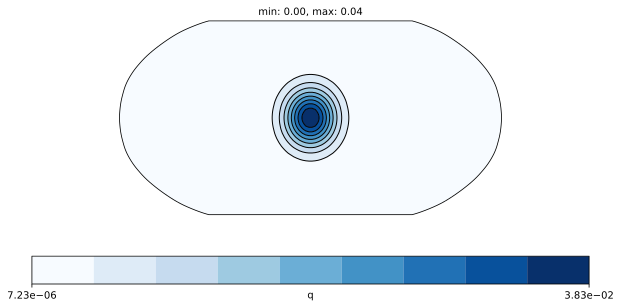

In [17]:
plot_field_latlon(q)

In [18]:
print_minmax(q)

min and max of q: 7.225721850253986e-06, 0.03843692381022076


  warnings.warn("Discontinuous Lagrange element requested on %s, creating DQ element." % cell.cellname())

  amean = a.mean()

  ret = ret.dtype.type(ret / rcount)



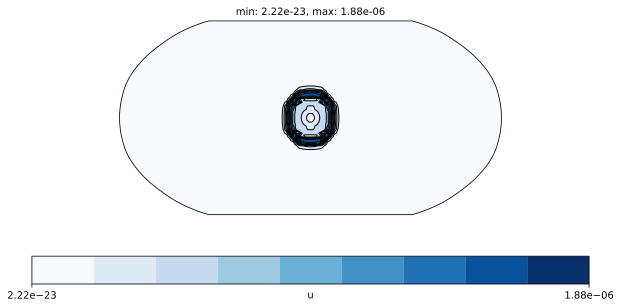

In [20]:
plot_field_latlon(u)

**Appendices**

***Aside: Why $\rho_0 C_p \Delta \theta w$?***

The heating terms $LP$ and $Q$ are column-integrated over the troposphere and are therefore balanced by column integrated ascent:
\begin{equation*}
\rho_0 C_p \int_{trop} w(z) \frac{d\theta}{dz} dz \sim \rho_0 C_p \Delta \theta \bar{w},
\end{equation*}
where $\bar{w}$ is column-mean $w$ and the overbar is subsequently omitted because all equations are column-mean.


**Doing a better job**

Some quantities that I recommend prescribing to begin with can actually be calculated.


***Tropospheric potential temperature difference***

Initially we set $\Delta \theta = 50$ K, but we can calculate it. Set
\begin{equation}
\Delta \theta = \frac{L}{C_p}(q_{max} - q_{UT}),
\end{equation}
where $q_{max}$ is the largest value of $q$, which is assumed to establish the tropical moist adiabatic lapse rate (as per some Isaac Held paper I can't remember currently).


***Sensible heat flux***

We want to avoid having a prognostic equation for boundary layer temperatures (this is what Bob is interested in in his papers), but if we had an estimate of boundary layer temperature then we can estimate the air-sea temperature difference, which is important to evaporation. The sensible heat flux, $J$, is
\begin{equation}
J = \rho_0 C_H C_p |u| (T_S - T_{skin}),
\end{equation}
where $T_{skin}$ is the skin temperature of the ocean (rather than $T_S$ which is really "near surface temperature", which would be measured by weather stations and would correspond to our $\theta$ at the surface.
Note that we assume that $C_H$ is the same as for evaporation, which is not always done. You then rearrange this expression to provide a value of the air-sea temperature difference.


**Optimisation**

We want
- $\int w\, dxdy = 0$. This is achieved by changing $q_C$. This also guarantees that net free atmospheric $LP$ and $Q_{cl}$ are balanced.
- To conserve moisture, $\int_{ascent} q w\, dxdy - P = \int_{descent} q_W w \,dxdy$. Then iterate. NEED TO CHECK CALCULATION IN MY OWN CODE.
- $\Delta \theta = \frac{L}{C_p}(q_{max} - q_{UT})$. Just calculate once you have an estimate of $q_{max}$. Then iterate.
- $Q_{cl}$ and the air-sea temperature difference to be correct. I've been using an offline radiation code to calculate free tropospheric (cloud layer) and boundary layer radiative cooling. Boundary layer radiative cooling and $J$ are then forced to balance by the above sensible heat flux equation setting $T_S - T_{skin}$. Free tropopsheric radiative cooling balances $LP$ through the model equations. Then iterate. Fixing this and the moisture conservation should alleviate the need for large evaporation coefficients.
